Restarted jax (Python 3.12.0)

In [ ]:
import math
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp
import matplotlib
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax


matplotlib.rcParams.update({"font.size": 30})

class Func(eqx.Module):
    mlp: eqx.nn.MLP
    data_size: int
    hidden_size: int

    def __init__(self, data_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.data_size = data_size
        self.hidden_size = hidden_size
        self.mlp = eqx.nn.MLP(
            in_size=hidden_size,
            out_size=hidden_size * data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            # Note the use of a tanh final activation function. This is important to
            # stop the model blowing up. (Just like how GRUs and LSTMs constrain the
            # rate of change of their hidden states.)
            final_activation=jnn.tanh,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y).reshape(self.hidden_size, self.data_size)
    

class NeuralCDE(eqx.Module):
    initial: eqx.nn.MLP
    func: Func
    linear: eqx.nn.Linear

    def __init__(self, data_size, nb_classes, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        ikey, fkey, lkey = jr.split(key, 3)
        self.initial = eqx.nn.MLP(data_size, hidden_size, width_size, depth, key=ikey)
        self.func = Func(data_size, hidden_size, width_size, depth, key=fkey)
        self.linear = eqx.nn.Linear(hidden_size, nb_classes, key=lkey)

    def __call__(self, ts, coeffs, evolving_out=False):
        # Each sample of data consists of some timestamps `ts`, and some `coeffs`
        # parameterising a control path. These are used to produce a continuous-time
        # input path `control`.
        control = diffrax.CubicInterpolation(ts, coeffs)
        term = diffrax.ControlTerm(self.func, control).to_ode()
        solver = diffrax.Tsit5()
        dt0 = None
        y0 = self.initial(control.evaluate(ts[0]))
        if evolving_out:
            saveat = diffrax.SaveAt(ts=ts)
        else:
            saveat = diffrax.SaveAt(t1=True)
        solution = diffrax.diffeqsolve(
            term,
            solver,
            ts[0],
            ts[-1],
            dt0,
            y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=saveat,
        )
        if evolving_out:
            prediction = jax.vmap(lambda y: jnn.softmax(self.linear(y)))(solution.ys)
        else:
            prediction = jnn.softmax(self.linear(solution.ys[-1]))
        return prediction
    
def get_data(split="trian", task="condition"):
    ### Davide's Sleep ###
    import h5py
    import numpy as np
    data_folder = "data/new_sleep/"
    prefix = "train" if split == "train" else "valid"
    train_horizon = 500

    ### Davide's Sleep Data ###
    with h5py.File(data_folder+'dataset.h5', "r") as f:
        print("HDF5 Dataset Keys: %s" % f.keys())
        data = np.array(f[f'{prefix}_encod_data'])
    ys = data[:, :train_horizon:, :]

    labels = []
    with open(data_folder+f'{prefix}_annotations.csv', 'r') as f:
        for line in f:
            if 'subject' not in line:
                human = int(line.split(',')[0].strip())
                sleep_phase = int(line.split(',')[1].strip())
                labels.append((human, sleep_phase))
    labels = np.array(labels)
    labels = labels[:, 1] if task == "condition" else labels[:, 0]
    labels = labels-1 if task == "condition" else labels
    assert len(data) == len(labels)
    print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")
    print(f"Unique labels: {np.unique(labels)}")

    ## Turn the Labels into one-hot encoding
    nb_classes = len(np.unique(labels))
    labels = jax.nn.one_hot(labels, nb_classes)
    print(f"One-hot labels shape: {labels.shape}")
    ######################

    ts = jnp.broadcast_to(jnp.linspace(0, 1, ys.shape[1]), (ys.shape[0], ys.shape[1]))
    ys = jnp.concatenate([ts[:, :, None], ys], axis=-1)  # time is a channel

    coeffs = jax.vmap(diffrax.backward_hermite_coefficients)(ts, ys)

    _, _, data_size = ys.shape
    return ts, coeffs, labels, data_size, nb_classes

get_data(split="train", task="condition")

def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

HDF5 Dataset Keys: <KeysViewHDF5 ['train_encod_data', 'train_recon_data', 'valid_encod_data', 'valid_recon_data']>
Data shape: (6925, 500, 2), Labels shape: (6925,)
Unique labels: [0 1 2 3 4]
One-hot labels shape: (6925, 5)


In [ ]:
batch_size,=3200,
lr,=1e-2,
steps,=500,
hidden_size,=8,
width_size,=128,
depth,=1,
seed,=5678,


#####-----------------####################

key = jr.PRNGKey(seed)
train_data_key, test_data_key, model_key, loader_key = jr.split(key, 4)

ts, coeffs, labels, data_size, nb_classes = get_data(split="train", task="condition")

model = NeuralCDE(data_size, nb_classes, hidden_size, width_size, depth, key=model_key)

# Training loop like normal.

@eqx.filter_jit
def loss(model, ti, label_i, coeff_i):
    pred = jax.vmap(model)(ti, coeff_i)

    # # Binary cross-entropy
    # bxe = label_i * jnp.log(pred) + (1 - label_i) * jnp.log(1 - pred)
    # bxe = -jnp.mean(bxe)
    # acc = jnp.mean((pred > 0.5) == (label_i == 1))

    # Categorical cross-entropy
    bxe = jnp.mean(-jnp.sum(label_i * jnp.log(pred), axis=(-1,)))
    acc = jnp.mean(jnp.argmax(pred, axis=-1) == jnp.argmax(label_i, axis=-1))

    return bxe, acc

grad_loss = eqx.filter_value_and_grad(loss, has_aux=True)

@eqx.filter_jit
def make_step(model, data_i, opt_state):
    ti, label_i, *coeff_i = data_i
    (bxe, acc), grads = grad_loss(model, ti, label_i, coeff_i)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return bxe, acc, model, opt_state

scheduler = optax.exponential_decay(init_value=lr, transition_steps=steps//10, decay_rate=0.90)
optim = optax.adam(scheduler)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
for step, data_i in zip(range(steps), dataloader((ts, labels) + coeffs, batch_size, key=loader_key)):
    start = time.time()
    bxe, acc, model, opt_state = make_step(model, data_i, opt_state)
    end = time.time()

    if step % 100 == 0:
        print(
            f"Step: {step}, Loss: {bxe}, Accuracy: {acc}, Computation time: "
            f"{end - start}"
        )

HDF5 Dataset Keys: <KeysViewHDF5 ['train_encod_data', 'train_recon_data', 'valid_encod_data', 'valid_recon_data']>
Data shape: (6925, 500, 2), Labels shape: (6925,)
Unique labels: [0 1 2 3 4]
One-hot labels shape: (6925, 5)
Step: 0, Loss: 2.7026116847991943, Accuracy: 0.11812499910593033, Computation time: 9.546837329864502
Step: 100, Loss: 1.1518670320510864, Accuracy: 0.5484374761581421, Computation time: 6.603623867034912
Step: 200, Loss: 1.1021084785461426, Accuracy: 0.5721874833106995, Computation time: 6.849452257156372
Step: 300, Loss: 1.1006406545639038, Accuracy: 0.5718749761581421, Computation time: 6.844480514526367
Step: 400, Loss: 1.0555285215377808, Accuracy: 0.5974999666213989, Computation time: 9.504219055175781


HDF5 Dataset Keys: <KeysViewHDF5 ['train_encod_data', 'train_recon_data', 'valid_encod_data', 'valid_recon_data']>
Data shape: (770, 500, 2), Labels shape: (770,)
Unique labels: [0 1 2 3 4]
One-hot labels shape: (770, 5)
Test loss: 1.117146372795105, Test Accuracy: 0.5688311457633972
(500,)


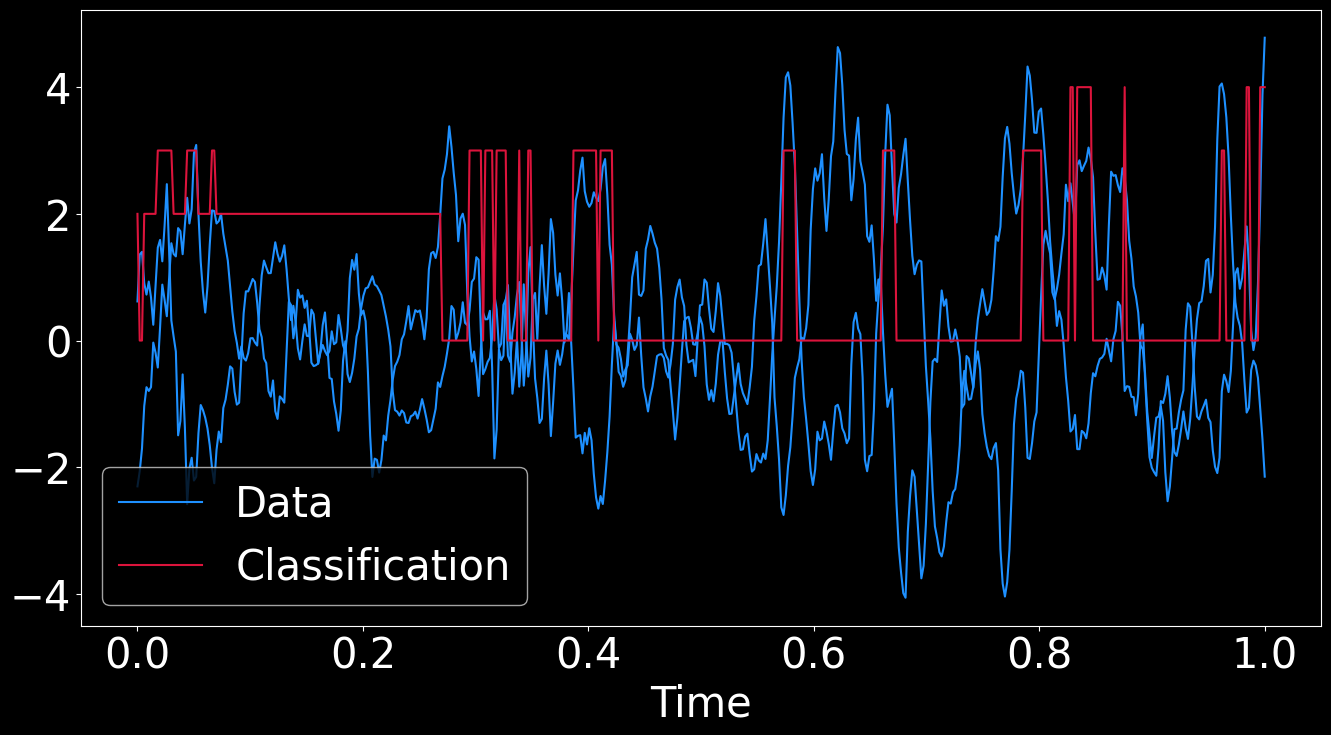

In [ ]:
ts, coeffs, labels, _, _ = get_data(split="test", task="condition")
bxe, acc = loss(model, ts, labels, coeffs)
print(f"Test loss: {bxe}, Test Accuracy: {acc}")

import numpy as np
test_id = np.random.randint(0, len(ts))
# Plot results
sample_ts = ts[test_id]
sample_coeffs = tuple(c[test_id] for c in coeffs)
pred = model(sample_ts, sample_coeffs, evolving_out=True)
pred = jnp.argmax(pred, axis=-1)
print(pred.shape)
interp = diffrax.CubicInterpolation(sample_ts, sample_coeffs)
values = jax.vmap(interp.evaluate)(sample_ts)
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 1, 1)
# ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax1.plot(sample_ts, values[:, 1], c="dodgerblue")
ax1.plot(sample_ts, values[:, 2], c="dodgerblue", label="Data")
ax1.plot(sample_ts, pred, c="crimson", label="Classification")
ax1.set_xlabel("Time")
ax1.legend()

# ax2.plot(values[:, 1], values[:, 2], c="dodgerblue", label="Data")
# ax2.plot(values[:, 1], values[:, 2], pred, c="crimson", label="Classification")
# ax2.set_xticks([])
# ax2.set_yticks([])
# ax2.set_zticks([])
# ax2.set_xlabel("x")
# ax2.set_ylabel("y")
# ax2.set_zlabel("Classification")
# plt.tight_layout()
# plt.savefig("tmp/neural_cde.png")
# plt.show()

In [ ]:
# Serialise the model
eqx.tree_serialise_leaves("tmp/kidger_cde.eqx", model)

HDF5 Dataset Keys: <KeysViewHDF5 ['train_encod_data', 'train_recon_data', 'valid_encod_data', 'valid_recon_data']>
Data shape: (770, 500, 2), Labels shape: (770,)
Unique labels: [0 1 2 3 4]
One-hot labels shape: (770, 5)
Test loss: 1.117146372795105, Test Accuracy: 0.5688311457633972
(500,)


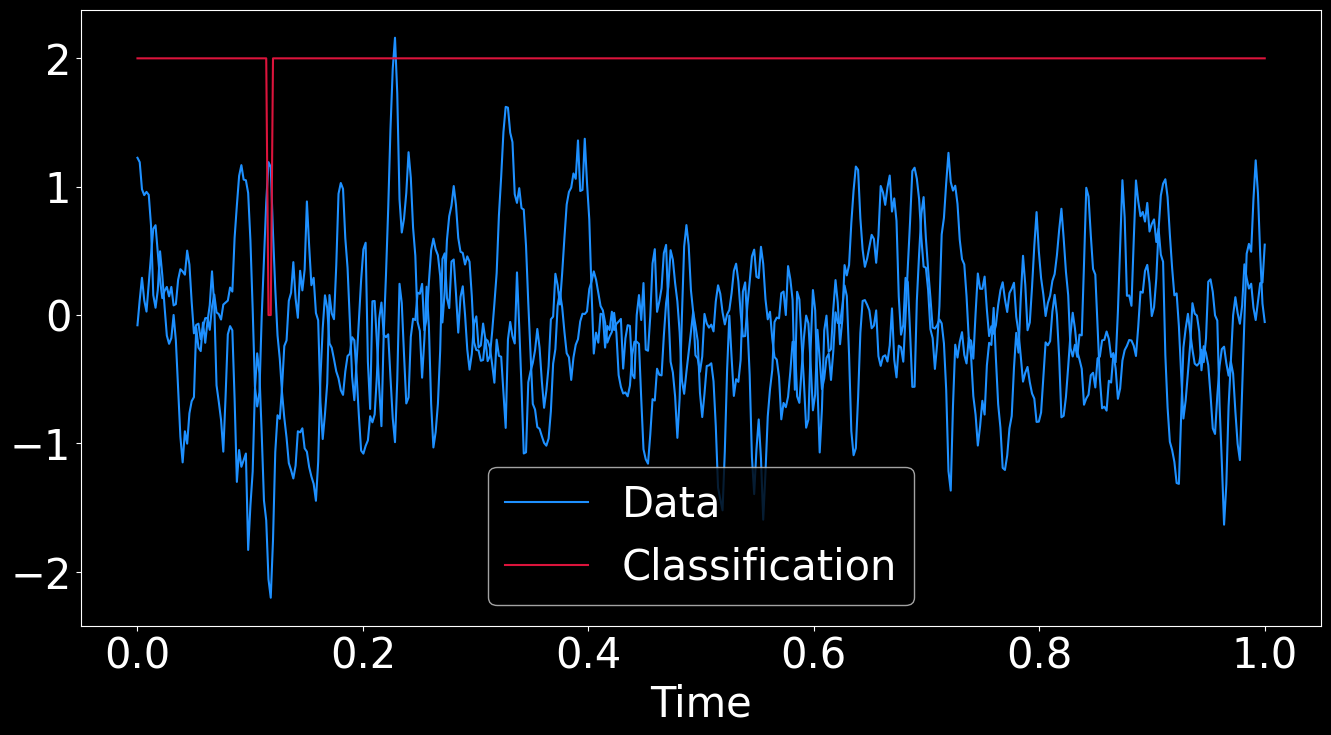

In [ ]:
ts, coeffs, labels, _, _ = get_data(split="test", task="condition")
bxe, acc = loss(model, ts, labels, coeffs)
print(f"Test loss: {bxe}, Test Accuracy: {acc}")

import numpy as np
test_id = np.random.randint(0, len(ts))
# Plot results
sample_ts = ts[test_id]
sample_coeffs = tuple(c[test_id] for c in coeffs)
pred = model(sample_ts, sample_coeffs, evolving_out=True)
pred = jnp.argmax(pred, axis=-1)
print(pred.shape)
interp = diffrax.CubicInterpolation(sample_ts, sample_coeffs)
values = jax.vmap(interp.evaluate)(sample_ts)
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 1, 1)
# ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax1.plot(sample_ts, values[:, 1], c="dodgerblue")
ax1.plot(sample_ts, values[:, 2], c="dodgerblue", label="Data")
ax1.plot(sample_ts, pred, c="crimson", label="Classification")
ax1.set_xlabel("Time")
ax1.legend()

# ax2.plot(values[:, 1], values[:, 2], c="dodgerblue", label="Data")
# ax2.plot(values[:, 1], values[:, 2], pred, c="crimson", label="Classification")
# ax2.set_xticks([])
# ax2.set_yticks([])
# ax2.set_zticks([])
# ax2.set_xlabel("x")
# ax2.set_ylabel("y")
# ax2.set_zlabel("Classification")
# plt.tight_layout()
# plt.savefig("tmp/neural_cde.png")
# plt.show()

HDF5 Dataset Keys: <KeysViewHDF5 ['train_encod_data', 'train_recon_data', 'valid_encod_data', 'valid_recon_data']>
Data shape: (770, 500, 2), Labels shape: (770,)
Unique labels: [0 1 2 3 4]
One-hot labels shape: (770, 5)
Test loss: 1.117146372795105, Test Accuracy: 0.5688311457633972
(500,)


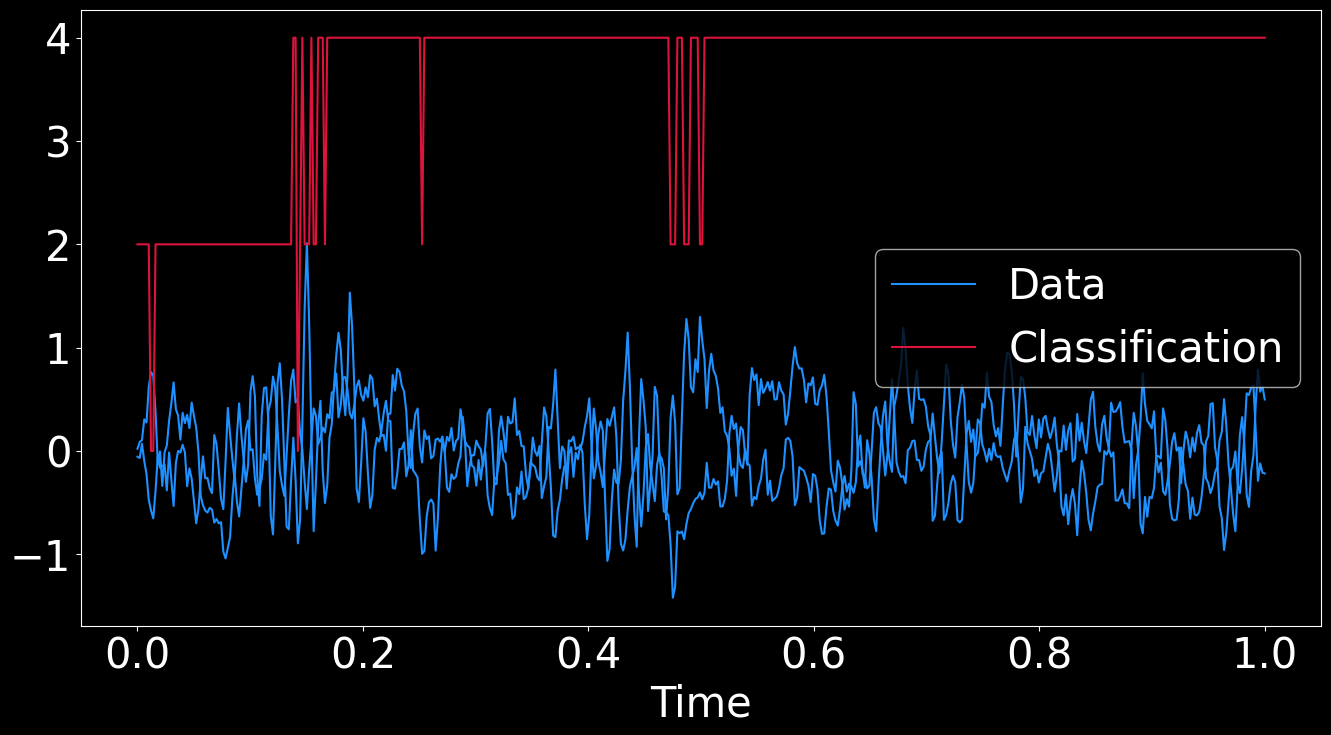

In [ ]:
ts, coeffs, labels, _, _ = get_data(split="test", task="condition")
bxe, acc = loss(model, ts, labels, coeffs)
print(f"Test loss: {bxe}, Test Accuracy: {acc}")

import numpy as np
test_id = np.random.randint(0, len(ts))
# Plot results
sample_ts = ts[test_id]
sample_coeffs = tuple(c[test_id] for c in coeffs)
pred = model(sample_ts, sample_coeffs, evolving_out=True)
pred = jnp.argmax(pred, axis=-1)
print(pred.shape)
interp = diffrax.CubicInterpolation(sample_ts, sample_coeffs)
values = jax.vmap(interp.evaluate)(sample_ts)
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 1, 1)
# ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax1.plot(sample_ts, values[:, 1], c="dodgerblue")
ax1.plot(sample_ts, values[:, 2], c="dodgerblue", label="Data")
ax1.plot(sample_ts, pred, c="crimson", label="Classification")
ax1.set_xlabel("Time")
ax1.legend()

# ax2.plot(values[:, 1], values[:, 2], c="dodgerblue", label="Data")
# ax2.plot(values[:, 1], values[:, 2], pred, c="crimson", label="Classification")
# ax2.set_xticks([])
# ax2.set_yticks([])
# ax2.set_zticks([])
# ax2.set_xlabel("x")
# ax2.set_ylabel("y")
# ax2.set_zlabel("Classification")
# plt.tight_layout()
# plt.savefig("tmp/neural_cde.png")
# plt.show()

HDF5 Dataset Keys: <KeysViewHDF5 ['train_encod_data', 'train_recon_data', 'valid_encod_data', 'valid_recon_data']>
Data shape: (770, 500, 2), Labels shape: (770,)
Unique labels: [0 1 2 3 4]
One-hot labels shape: (770, 5)
Test loss: 1.117146372795105, Test Accuracy: 0.5688311457633972
(500,)


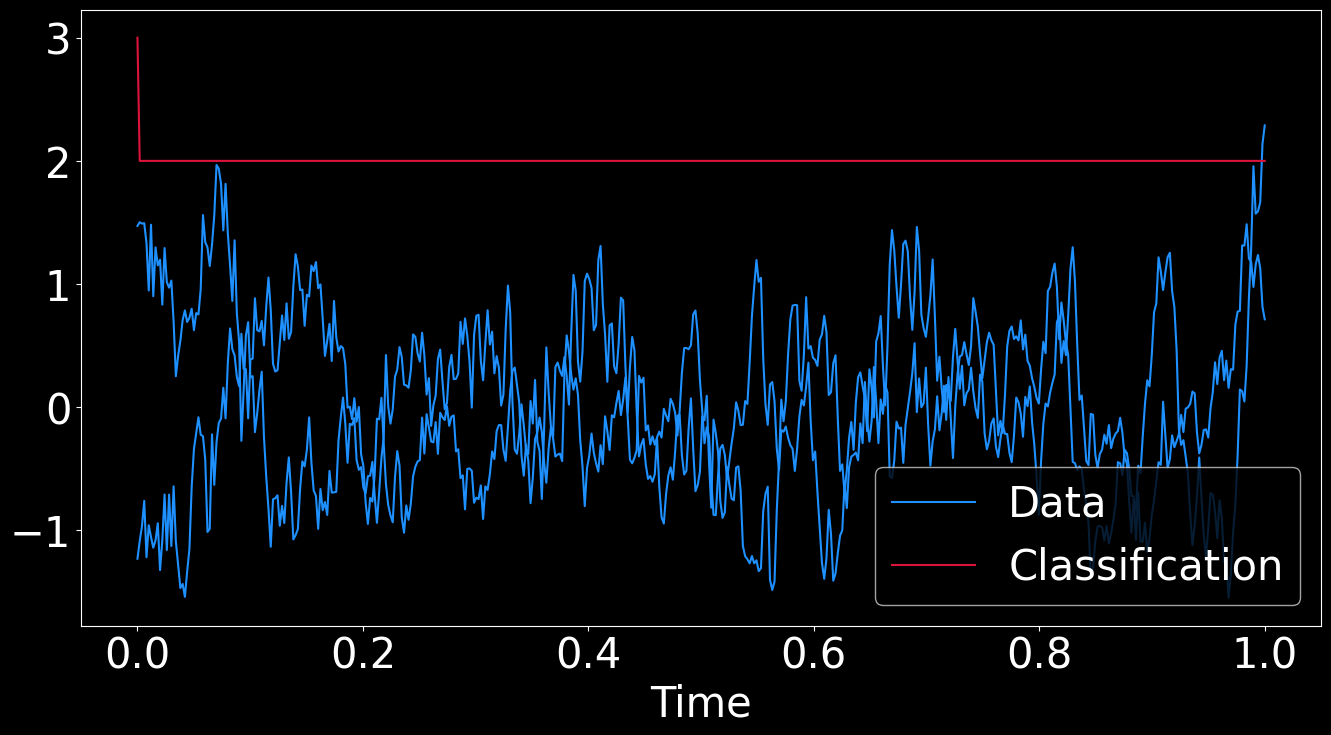

In [ ]:
ts, coeffs, labels, _, _ = get_data(split="test", task="condition")
bxe, acc = loss(model, ts, labels, coeffs)
print(f"Test loss: {bxe}, Test Accuracy: {acc}")

import numpy as np
test_id = np.random.randint(0, len(ts))
# Plot results
sample_ts = ts[test_id]
sample_coeffs = tuple(c[test_id] for c in coeffs)
pred = model(sample_ts, sample_coeffs, evolving_out=True)
pred = jnp.argmax(pred, axis=-1)
print(pred.shape)
interp = diffrax.CubicInterpolation(sample_ts, sample_coeffs)
values = jax.vmap(interp.evaluate)(sample_ts)
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 1, 1)
# ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax1.plot(sample_ts, values[:, 1], c="dodgerblue")
ax1.plot(sample_ts, values[:, 2], c="dodgerblue", label="Data")
ax1.plot(sample_ts, pred, c="crimson", label="Classification")
ax1.set_xlabel("Time")
ax1.legend()

# ax2.plot(values[:, 1], values[:, 2], c="dodgerblue", label="Data")
# ax2.plot(values[:, 1], values[:, 2], pred, c="crimson", label="Classification")
# ax2.set_xticks([])
# ax2.set_yticks([])
# ax2.set_zticks([])
# ax2.set_xlabel("x")
# ax2.set_ylabel("y")
# ax2.set_zlabel("Classification")
# plt.tight_layout()
# plt.savefig("tmp/neural_cde.png")
# plt.show()

HDF5 Dataset Keys: <KeysViewHDF5 ['train_encod_data', 'train_recon_data', 'valid_encod_data', 'valid_recon_data']>
Data shape: (770, 500, 2), Labels shape: (770,)
Unique labels: [0 1 2 3 4]
One-hot labels shape: (770, 5)
Test loss: 1.117146372795105, Test Accuracy: 0.5688311457633972
(500,)


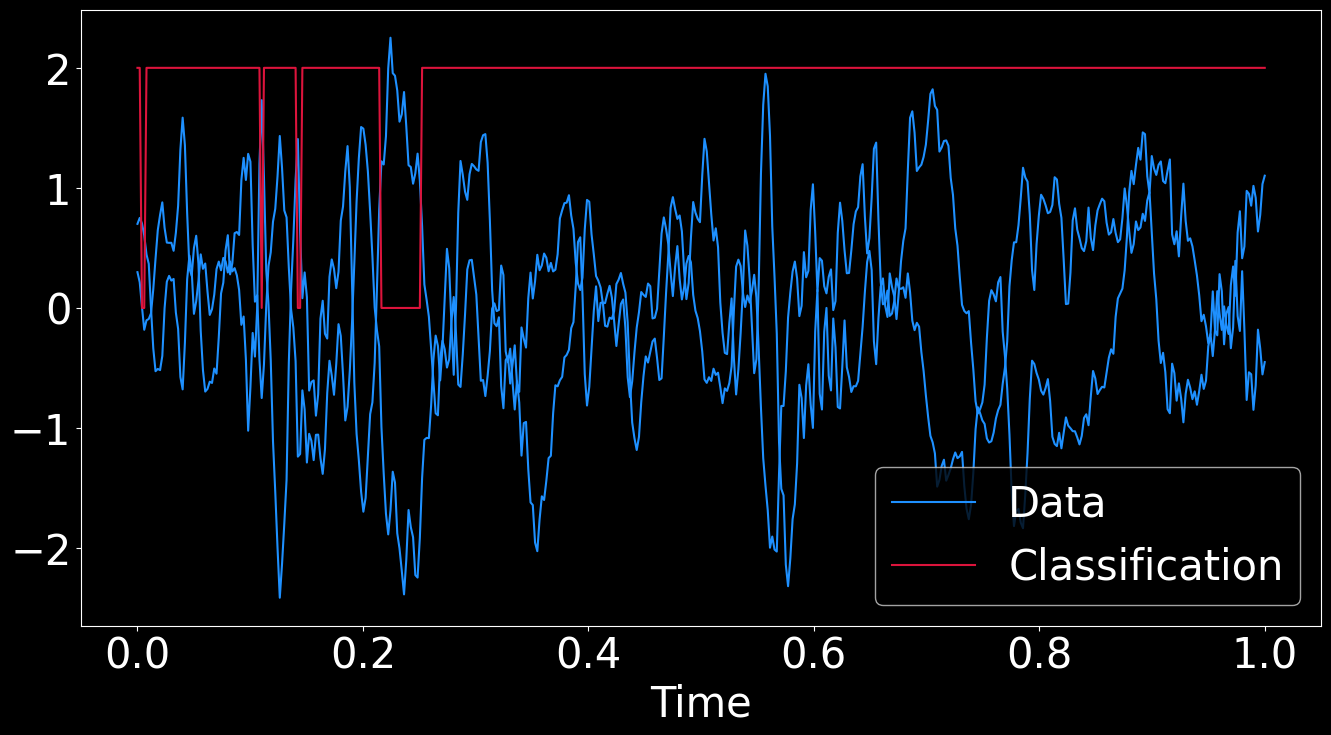

In [ ]:
ts, coeffs, labels, _, _ = get_data(split="test", task="condition")
bxe, acc = loss(model, ts, labels, coeffs)
print(f"Test loss: {bxe}, Test Accuracy: {acc}")

import numpy as np
test_id = np.random.randint(0, len(ts))
# Plot results
sample_ts = ts[test_id]
sample_coeffs = tuple(c[test_id] for c in coeffs)
pred = model(sample_ts, sample_coeffs, evolving_out=True)
pred = jnp.argmax(pred, axis=-1)
print(pred.shape)
interp = diffrax.CubicInterpolation(sample_ts, sample_coeffs)
values = jax.vmap(interp.evaluate)(sample_ts)
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 1, 1)
# ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax1.plot(sample_ts, values[:, 1], c="dodgerblue")
ax1.plot(sample_ts, values[:, 2], c="dodgerblue", label="Data")
ax1.plot(sample_ts, pred, c="crimson", label="Classification")
ax1.set_xlabel("Time")
ax1.legend()

# ax2.plot(values[:, 1], values[:, 2], c="dodgerblue", label="Data")
# ax2.plot(values[:, 1], values[:, 2], pred, c="crimson", label="Classification")
# ax2.set_xticks([])
# ax2.set_yticks([])
# ax2.set_zticks([])
# ax2.set_xlabel("x")
# ax2.set_ylabel("y")
# ax2.set_zlabel("Classification")
# plt.tight_layout()
# plt.savefig("tmp/neural_cde.png")
# plt.show()

HDF5 Dataset Keys: <KeysViewHDF5 ['train_encod_data', 'train_recon_data', 'valid_encod_data', 'valid_recon_data']>
Data shape: (770, 500, 2), Labels shape: (770,)
Unique labels: [0 1 2 3 4]
One-hot labels shape: (770, 5)
Test loss: 1.117146372795105, Test Accuracy: 0.5688311457633972
(500,)


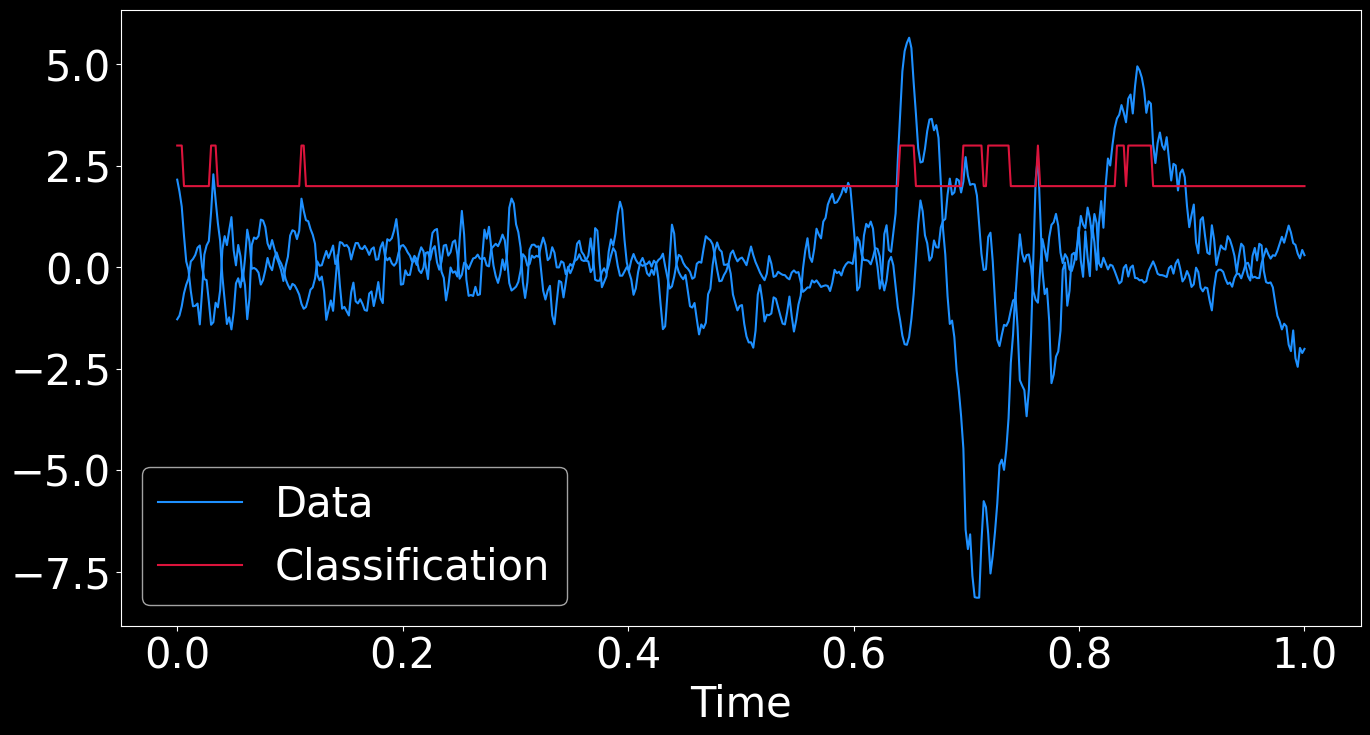

In [ ]:
ts, coeffs, labels, _, _ = get_data(split="test", task="condition")
bxe, acc = loss(model, ts, labels, coeffs)
print(f"Test loss: {bxe}, Test Accuracy: {acc}")

import numpy as np
test_id = np.random.randint(0, len(ts))
# Plot results
sample_ts = ts[test_id]
sample_coeffs = tuple(c[test_id] for c in coeffs)
pred = model(sample_ts, sample_coeffs, evolving_out=True)
pred = jnp.argmax(pred, axis=-1)
print(pred.shape)
interp = diffrax.CubicInterpolation(sample_ts, sample_coeffs)
values = jax.vmap(interp.evaluate)(sample_ts)
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 1, 1)
# ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax1.plot(sample_ts, values[:, 1], c="dodgerblue")
ax1.plot(sample_ts, values[:, 2], c="dodgerblue", label="Data")
ax1.plot(sample_ts, pred, c="crimson", label="Classification")
ax1.set_xlabel("Time")
ax1.legend()

# ax2.plot(values[:, 1], values[:, 2], c="dodgerblue", label="Data")
# ax2.plot(values[:, 1], values[:, 2], pred, c="crimson", label="Classification")
# ax2.set_xticks([])
# ax2.set_yticks([])
# ax2.set_zticks([])
# ax2.set_xlabel("x")
# ax2.set_ylabel("y")
# ax2.set_zlabel("Classification")
# plt.tight_layout()
# plt.savefig("tmp/neural_cde.png")
# plt.show()

In [ ]:
# Let's calculate the per-class accuracy
pred = model(ts, coeffs, evolving_out=False)
pred = jnp.argmax(pred, axis=-1)
true = jnp.argmax(labels, axis=-1)

# Calculate the per-class accuracy
per_class_acc = []
for i in range(nb_classes):
    mask = true == i
    per_class_acc.append(jnp.mean(pred[mask] == true[mask]))
per_class_acc = jnp.array(per_class_acc)
print(per_class_acc)

ValueError: Each cubic coefficient must have `times - 1` entries, where `times = self.ts.shape[0]`.

In [ ]:
# Let's calculate the per-class accuracy
pred = model(ts, coeffs, evolving_out=True)[-1]
pred = jnp.argmax(pred, axis=-1)
true = jnp.argmax(labels, axis=-1)

# Calculate the per-class accuracy
per_class_acc = []
for i in range(nb_classes):
    mask = true == i
    per_class_acc.append(jnp.mean(pred[mask] == true[mask]))
per_class_acc = jnp.array(per_class_acc)
print(per_class_acc)

ValueError: Each cubic coefficient must have `times - 1` entries, where `times = self.ts.shape[0]`.

In [ ]:
# Let's calculate the per-class accuracy
pred = eqx.filter_vmap(model)(ts, coeffs, evolving_out=False)
pred = jnp.argmax(pred, axis=-1)
true = jnp.argmax(labels, axis=-1)

# Calculate the per-class accuracy
per_class_acc = []
for i in range(nb_classes):
    mask = true == i
    per_class_acc.append(jnp.mean(pred[mask] == true[mask]))
per_class_acc = jnp.array(per_class_acc)
print(per_class_acc)

RuntimeError: keyword arguments cannot be used with functions wrapped with `filter_vmap`

In [ ]:
# Let's calculate the per-class accuracy
pred = eqx.filter_vmap(lambda ts, coeffs: model(ts, coeffs, evolving_out=False))(ts, coeffs)
pred = jnp.argmax(pred, axis=-1)
true = jnp.argmax(labels, axis=-1)

# Calculate the per-class accuracy
per_class_acc = []
for i in range(nb_classes):
    mask = true == i
    per_class_acc.append(jnp.mean(pred[mask] == true[mask]))
per_class_acc = jnp.array(per_class_acc)
print(per_class_acc)

[0.5123967  0.         0.78994083 0.36734694 0.53900707]
